# Predict yet to arrive 

The notebook shows how to prepare a model that will predict the number of patients yet to arrive.

Inputs
- A series of times in the day at which we want to make these predictions is set, saved in an array called prediction_times. Each prediction time is saved as a tuple. Eg 6 am is saved as (6,0)
- A series of dates on which we want to make these predictions
- A window after the prediction time, within which we are interested in predicting a number of patients (eg 8 hours)

## Set up the notebook environment

In [19]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from pathlib import Path
import sys
import json
import pandas as pd

root = Path().resolve().parent

sys.path.append(str(root/ 'src' / 'patientflow'))

## Load parameters and set file paths

In [12]:
# indicate whether the notebook is being run locally for UCLH or with public datasets
uclh = False
from patientflow.load import set_file_paths
from patientflow.load import load_config_file

# set file locations
data_folder_name = 'data-uclh' if uclh else 'data-public'
data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
        train_dttm = None, data_folder_name = data_folder_name, uclh = uclh, from_notebook=True, inference_time = False)

# load params
params = load_config_file(config_path)

prediction_times = params["prediction_times"]
start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]
x1, y1, x2, y2 = params["x1"], params["y1"], params["x2"], params["y2"]
prediction_window = params["prediction_window"]
epsilon = float(params["epsilon"])
yta_time_interval = params["yta_time_interval"]

print(f'\nTraining set starts {start_training_set} and ends on {start_validation_set - pd.Timedelta(days=1)} inclusive')
print(f'Validation set starts on {start_validation_set} and ends on {start_test_set - pd.Timedelta(days=1)} inclusive' )
print(f'Test set starts on {start_test_set} and ends on {end_test_set- pd.Timedelta(days=1)} inclusive' )

print(f'\nThe coordinates used to derive the aspirational curve are ({int(x1)},{y1}) and ({int(x2)},{y2})')
print(f'The prediction window over which prediction will be made is {prediction_window/60} hours')
print(f'In order to calculate yet-to-arrive rates of arrival, the prediction window will be divied into intervals of {yta_time_interval} minutes')

Configuration will be loaded from: /Users/zellaking/Repos/patientflow/config.yaml
Data files will be loaded from: /Users/zellaking/Repos/patientflow/data-public
Trained models will be saved to: /Users/zellaking/Repos/patientflow/trained-models
Images will be saved to: /Users/zellaking/Repos/patientflow/notebooks/img

Training set starts 2031-03-01 and ends on 2031-08-31 inclusive
Validation set starts on 2031-09-01 and ends on 2031-09-30 inclusive
Test set starts on 2031-10-01 and ends on 2031-12-31 inclusive

The coordinates used to derive the aspirational curve are (4,0.76) and (12,0.99)
The prediction window over which prediction will be made is 8.0 hours
In order to calculate yet-to-arrive rates of arrival, the prediction window will be divied into intervals of 15 minutes


## Load data

In [35]:
import pandas as pd
from patientflow.load import set_data_file_names
from patientflow.load import data_from_csv

if uclh:
    visits_path, visits_csv_path, yta_path, yta_csv_path = set_data_file_names(uclh, data_file_path, config_path)
else:
    visits_csv_path, yta_csv_path = set_data_file_names(uclh, data_file_path)

yta = pd.read_csv(yta_csv_path)




In [36]:
yta.head()

,training_validation_test,arrival_datetime,sex,specialty,is_child
0,train,03/01/2031 05:12:49,F,medical,True
1,train,03/01/2031 04:54:25,F,medical,False
2,train,03/01/2031 21:13:25,M,haem/onc,False
3,train,03/01/2031 10:05:59,M,surgical,False
4,train,03/01/2031 10:55:40,M,medical,False


## Separate into training, validation and test sets

As part of preparing the data, each visit has already been allocated into one of three sets - training, vaidation and test sets. 

In [37]:
yta.training_validation_test.value_counts()

training_validation_test
train    7729
test     3665
valid    1242
Name: count, dtype: int64

In [38]:
train_yta = yta[yta.training_validation_test == 'train']#.drop(columns='training_validation_test')
valid_yta = yta[yta.training_validation_test == 'valid']#.drop(columns='training_validation_test')
test_yta = yta[yta.training_validation_test == 'test']#.drop(columns='training_validation_test')


assert pd.to_datetime(train_yta['arrival_datetime'], utc = True).dt.date.min() == start_training_set
assert pd.to_datetime(train_yta['arrival_datetime'], utc = True).dt.date.max() < start_validation_set
assert pd.to_datetime(valid_yta['arrival_datetime'], utc = True).dt.date.min() == start_validation_set
assert pd.to_datetime(valid_yta['arrival_datetime'], utc = True).dt.date.max() < start_test_set
assert pd.to_datetime(test_yta['arrival_datetime'], utc = True).dt.date.min() == start_test_set
assert pd.to_datetime(test_yta['arrival_datetime'], utc = True).dt.date.max() < end_test_set

The Weighted Poisson model requires as input a dataframe with the index set as the arrival datetimes of each visit. We set that here

In [39]:
train_yta['arrival_datetime'] = pd.to_datetime(train_yta['arrival_datetime'], utc = True)
train_yta.set_index('arrival_datetime', inplace=True)

/var/folders/lr/pm79dxzs0v70y4gz98dl13440000gn/T/ipykernel_41944/3438003292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_yta['arrival_datetime'] = pd.to_datetime(train_yta['arrival_datetime'], utc = True)


In [40]:
isinstance(train_yta.index, pd.DatetimeIndex)

True

## Train the Weighted Poisson model

The weighted Poisson model provides a way to predict yet to arrive patients under the assumption that the ED/SDEC is meeting targets for how long it takes to admit patients. The aspirational targets are set as parameters in config.yaml and have been loaded at the top of this notebook. 

To see the parameters:

In [41]:
print(f'The aspiration is that within {str(x1)} hours of arrival, {str(y1*100)}% of patients will have been admitted, and that witin {str(x2)} hours of arrival, {str(y2*100)}% of patients will have been admitted')

The aspiration is that within 4.0 hours of arrival, 76.0% of patients will have been admitted, and that witin 12.0 hours of arrival, 99.0% of patients will have been admitted


The aspiration can be plotted as a curve to see the shape of the curve. Here we have assumed that the majority of admissions happen between 3 and 4 hours of arrival, where the slope of the curve is steepest. 

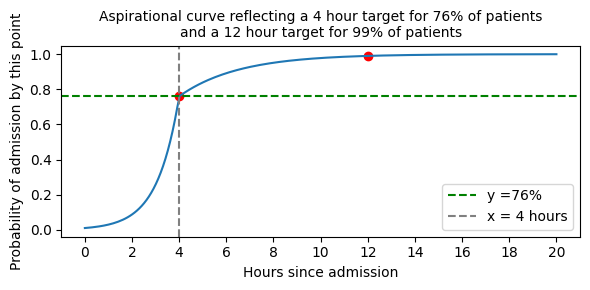

In [42]:
from patientflow.viz.aspirational_curve_plot import plot_curve

figsize = (6,3)

plot_curve(
    title = 'Aspirational curve reflecting a ' + str(int(x1)) + ' hour target for ' + str(int(y1*100)) + \
        '% of patients\nand a '+ str(int(x2)) + ' hour target for ' + str(int(y2*100)) + '% of patients',
    x1 = x1,
    y1 = y1,
    x2 = x2,
    y2 = y2,
    include_titles=True,
    text_size=None,
    directory_path=None,
    file_name=None,
)


### Predict for all admissions, irrespective of specialty of admission

In [43]:
from patientflow.predictors.weighted_poisson_predictor import WeightedPoissonPredictor
from joblib import dump, load

model =  WeightedPoissonPredictor()

model.fit(train_yta, prediction_window, yta_time_interval, prediction_times)

MODEL__ED_YETTOARRIVE__NAME = 'ed_yet_to_arrive_all_' + str(int(prediction_window/60)) + '_hours'
full_path = model_file_path / MODEL__ED_YETTOARRIVE__NAME 
full_path = full_path.with_suffix('.joblib')

dump(model, full_path)

Calculating time-varying arrival rates for data provided, which spans 184 unique dates
Poisson Binomial Predictor trained for these times: [(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)]
using prediction window of 480 minutes after the time of prediction
and time interval of 15 minutes within the prediction window.
The error value for prediction will be 1e-07
To see the weights saved by this model, used the get_weights() method


['/Users/zellaking/Repos/patientflow/trained-models/ed_yet_to_arrive_all_8_hours.joblib']

To see the predicted distribution of patients yet-to-arrive at 6.00 am, call the model as follows:

In [44]:
prediction_context = {
    'default': {
        'prediction_time': tuple([7, 0])  
    }
}

MODEL__ED_YETTOARRIVE__NAME = 'ed_yet_to_arrive_all_' + str(int(prediction_window/60)) + '_hours'
full_path = model_file_path / MODEL__ED_YETTOARRIVE__NAME 
full_path = full_path.with_suffix('.joblib')

model = load(full_path)

preds = model.predict(prediction_context, x1, y1, x2, y2)
preds

/Users/zellaking/Repos/patientflow/src/patientflow/predictors/weighted_poisson_predictor.py:210: UserWarning: Time of day requested of (7, 0) was not in model training. Reverting to predictions for (6, 0).
  warnings.warn(


{'default':          agg_proba
 sum               
 0     5.006736e-04
 1     3.804897e-03
 2     1.445776e-02
 3     3.662419e-02
 4     6.958190e-02
 ..             ...
 220  5.970315e-311
 221  2.750276e-314
 222  9.838151e-318
 223  2.435744e-321
 224   0.000000e+00
 
 [225 rows x 1 columns]}

To see the output visually we can plot this using the 

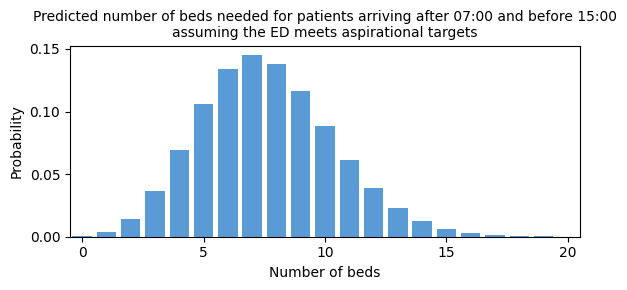

In [45]:
from patientflow.viz.prob_dist_plot import prob_dist_plot

hour, minute = prediction_context['default']['prediction_time']
start_time = f"{hour:02}:{minute:02}"
end_time = f"{int(hour + prediction_window / 60):02}:{minute:02}"

title = f"Predicted number of beds needed for patients arriving after {start_time} and before {end_time}\nassuming the ED meets aspirational targets"

prob_dist_plot(preds['default'], 
               title=title, 
               include_titles=True)

### Predict within specialty

To train a model of yet-to-arrive patients within specialty, we can use filters as shown below. Here, if an arrival is a child, we assume they will be admitted to a paediatric specialty by default

In [46]:
from patientflow.predictors.weighted_poisson_predictor import WeightedPoissonPredictor
from joblib import dump, load

model =  WeightedPoissonPredictor()

specialty_filters = {
    'medical': {'specialty': 'medical', 'is_child': False},
    'surgical': {'specialty': 'surgical', 'is_child': False},
    'haem/onc': {'specialty': 'haem/onc', 'is_child': False},
    'paediatric': {'is_child': True}  # Pediatric doesn't filter by observed_specialty
}

model_by_spec =  WeightedPoissonPredictor(filters = specialty_filters)

model_by_spec.fit(train_yta, prediction_window, yta_time_interval, prediction_times)


MODEL__ED_YETTOARRIVE__NAME = 'ed_yet_to_arrive_by_spec_' + str(int(prediction_window/60)) + '_hours'
full_path = model_file_path / MODEL__ED_YETTOARRIVE__NAME 
full_path = full_path.with_suffix('.joblib')

dump(model_by_spec, full_path)

Calculating time-varying arrival rates for data provided, which spans 184 unique dates
Calculating time-varying arrival rates for data provided, which spans 184 unique dates
Calculating time-varying arrival rates for data provided, which spans 182 unique dates
Calculating time-varying arrival rates for data provided, which spans 183 unique dates
Poisson Binomial Predictor trained for these times: [(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)]
using prediction window of 480 minutes after the time of prediction
and time interval of 15 minutes within the prediction window.
The error value for prediction will be 1e-07
To see the weights saved by this model, used the get_weights() method


['/Users/zellaking/Repos/patientflow/trained-models/ed_yet_to_arrive_by_spec_8_hours.joblib']

In [47]:
MODEL__ED_YETTOARRIVE__NAME = 'ed_yet_to_arrive_by_spec_' + str(int(prediction_window/60)) + '_hours'
full_path = model_file_path / MODEL__ED_YETTOARRIVE__NAME 
full_path = full_path.with_suffix('.joblib')

model_by_spec = load(full_path)

prediction_context = {
    'medical': {
        'prediction_time': tuple([7, 0])  
    }
}

preds = model_by_spec.predict(prediction_context, x1, y1, x2, y2)
preds['medical']

/Users/zellaking/Repos/patientflow/src/patientflow/predictors/weighted_poisson_predictor.py:210: UserWarning: Time of day requested of (7, 0) was not in model training. Reverting to predictions for (6, 0).
  warnings.warn(


,agg_proba
sum,
0,2.396250e-02
1,8.941045e-02
2,1.668070e-01
3,2.074671e-01
4,1.935287e-01
...,...
188,1.808145e-312
189,5.369924e-316
190,1.245589e-319


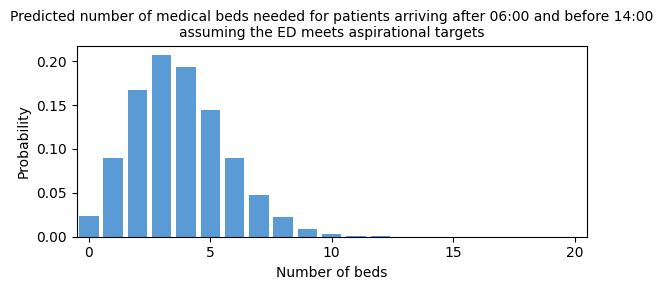

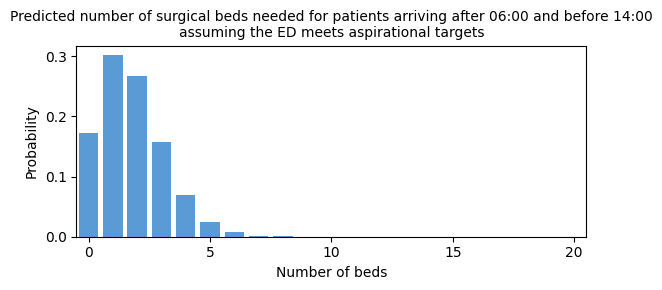

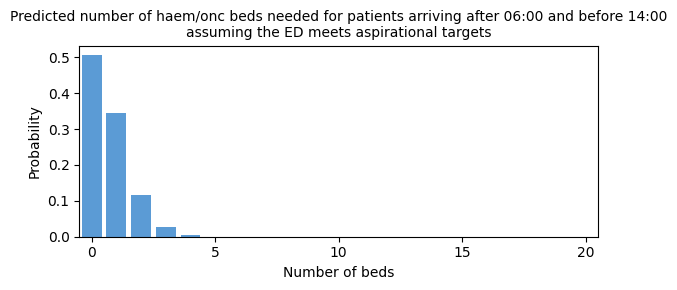

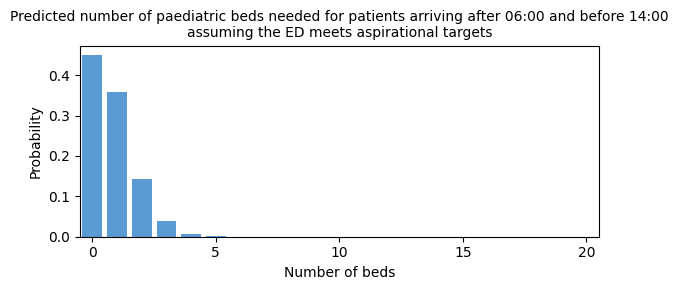

In [49]:
from patientflow.viz.prob_dist_plot import prob_dist_plot

for spec in specialty_filters:
    prediction_context = {
    spec: {
        'prediction_time': tuple([6, 0])  
        }
    }

    preds = model_by_spec.predict(prediction_context, x1, y1, x2, y2)

    hour, minute = prediction_context[spec]['prediction_time']
    start_time = f"{hour:02}:{minute:02}"
    end_time = f"{int(hour + prediction_window / 60):02}:{minute:02}"

    title = f"Predicted number of {spec} beds needed for patients arriving after {start_time} and before {end_time}\nassuming the ED meets aspirational targets"

    prob_dist_plot(preds[spec], 
                title=title, 
                include_titles=True) 